In [6]:
import os
import fnmatch
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit 
import numpy as np
import sys
sys.path.insert(1, r'C:\Users\eliot\EPFL\TP4_ECAL\Code\ecal_reco\utils')
from parameters import *
current_directory = os.getcwd()
data_directory = current_directory+"\\extracted_data\\"

In [7]:
# list of time interval data (file names) that will be concatenated for the histogram. If empty, all time interval files will be concatenated
# files = ["time_intervals_10_h.txt"]
# files = ["time_intervals_run_000154.txt"]
# files = ["time_intervals_10h.txt","time_intervals_run_000154.txt"]
files = ["time_intervals_run_000010.txt"]

In [8]:
if len(files) == 0:
    files = fnmatch.filter(os.listdir(data_directory), 'time_interval*')
time_intervals = np.array([])
for file in files:
    ti = np.loadtxt(data_directory+file)
    time_intervals = np.append(time_intervals,ti)
time_intervals*=clockcycle_value

In [9]:
# Exponential function for the fit
def exponential(x,A,tau):
    return A*np.exp(-x/tau)

<>:13: SyntaxWarning: invalid escape sequence '\D'
<>:13: SyntaxWarning: invalid escape sequence '\D'
C:\Users\eliot\AppData\Local\Temp\ipykernel_46636\3778196538.py:13: SyntaxWarning: invalid escape sequence '\D'
  ax.set_xlabel("$\Delta t$")


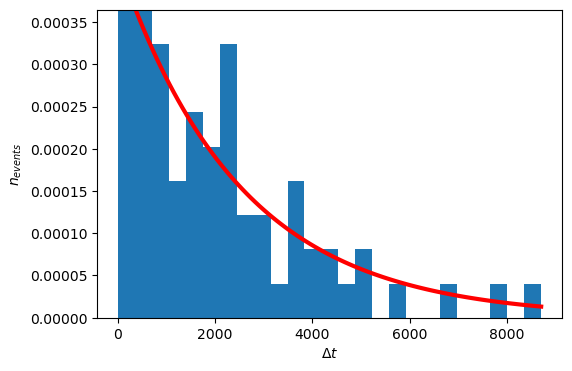

Muon lifetime : τ = 2511.1232974847208 ± 314.5483681443172 ns


In [10]:
# Plot of the distribution of decay time
from scipy.optimize import curve_fit

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
n,bins,_ = ax.hist(time_intervals, 25, density=True)
bins_centers = (bins[1:]+bins[:-1])/2

coeffs, cov = curve_fit(exponential,bins_centers,n,p0=[0.0005,2000])

t = np.linspace(min(time_intervals),max(time_intervals),100)

ax.plot(t, exponential(t,*coeffs), '-r', lw=3)
ax.set_xlabel("$\Delta t$")
ax.set_ylabel("$n_{events}$")
ax.set_ylim(0,max(n))
plt.show()
fig.savefig("muon_lifetime.pdf", format="pdf", bbox_inches="tight")

tau = coeffs[1]
tau_std = np.sqrt(cov[1,1])

print("Muon lifetime : \u03C4 = {} \u00B1 {} ns".format(tau,tau_std))

In [ ]:
def chisquare_manual(observed_values,expected_values):

    test_statistic=0

    for observed, expected in zip(observed_values, expected_values):

        test_statistic+=(float(observed)-float(expected))**2/float(expected)

    return test_statistic

In [ ]:
## zfit package not compatible with 3.12 python

import zfit
import mplhep
from uncertainties import unumpy, ufloat
from scipy.stats import chisquare
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import zfit
from zfit import z as ztf
import matplotlib.patches as mpatches
import math
isDebug = False
def plotFit(
    pdf,
    data,
    plotList,
    x_label,
    y_label=None,
    nbins=50,
    plot_pull=True,
    logy=False,
    rangeX=None,
    rangeY=None,
    plot_chi2 = False,
    **kwargs):

    _range = rangeX if rangeX else pdf.space.limit1d

    ## data --> histogram
    datay, bin_edges = np.histogram(data, bins=nbins, range=_range)
    errory = np.sqrt(datay)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    binwidth = (_range[1] - _range[0]) / nbins

    ## the pdf normalization
    try:
        integral_pdf = pdf.ext_integrate(_range)
    # except NotExtendedPDFError:
    except AttributeError:
        integral_pdf = pdf.integrate(_range)
    if isDebug: 
        print(f"Integral of extended pdf: N = {integral_pdf}")
        print(f"Integral of  pdf: I = {pdf.integrate(_range)}")
        print("Normalization range", pdf.norm_range)


    if pdf.is_extended:
        N = zfit.run(integral_pdf)
        integral_pdf = integral_pdf / pdf.get_yield()
        if isDebug: print(f"Calculated from extended pdf: N = {N}")
    else:
        N = np.sum(datay)
        if isDebug: print(f"Calculated from datay array: N = {N}")

    norm = N * binwidth
    if isDebug: 
        print(f"Range = {_range}")
        print(f"Norm = {norm}")



    if not rangeY:
        if logy:
            if isDebug: 
                print(min(datay), max(datay))
            rangeY = (min(datay)*0.1 + 1, max(datay) * 10.0)
        else:
            rangeY = (0.01, max(datay) * 1.2)
            # pass

    yscale = "log" if logy else ""

    x = np.linspace(*_range, num=1000)

    # LHCbStyle()

    if plot_pull:
        if kwargs.get("ax1", None) is not None:
            ax1 = kwargs["ax1"]
            f = None
        else:
            f = plt.figure()
            gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1], hspace=0.125)
            ax1 = plt.subplot(gs[0])
    else:
        ax1 = kwargs.get("ax1", None)
        if ax1 is None:
            ax1 = plt.gca()
        f = None

    # plot data
    if not "data" in plotList.keys():
        plotList["data"] = {"color": "black", "label": "Data"}
    datacolor = plotList["data"].get("color", "black")
    datalabel = plotList["data"].get("label", "Data")
    mplhep.histplot(
        datay,
        bins=bin_edges,
        label=datalabel,
        ax=ax1,
        histtype="errorbar",
        color=datacolor,
        markersize=4,
        yerr=True,
        elinewidth=1.5,
    )


    # plot model
    if not "fullmodel" in plotList.keys():
        plotList["fullmodel"] = {"color": "blue", "label": "Full model"}
    fmodelcolor = plotList["fullmodel"].get("color", "blue")
    fmodellabel = plotList["fullmodel"].get("label", "Full model")

    try:
        toplot = []
        toresiduals = []
        for i, (m, frac) in enumerate(zip(pdf.get_models(), pdf.fracs)):
            if m.is_extended:
                _frac = (frac / integral_pdf) * (m.ext_integrate(_range) / m.get_yield())
            else:
                _frac = (frac / integral_pdf) * m.integrate(_range)
            y = zfit.run(m.pdf(x, norm_range=_range) * _frac * norm)
            yb = zfit.run(m.pdf(bin_centers, norm_range=_range) * _frac * norm)
            toplot.append(y)
            toresiduals.append(yb)

        _ = ax1.plot(
            x, np.sum(toplot, axis=0), color=fmodelcolor, lw=2, label=fmodellabel
        )

        prop_cycle = plt.rcParams["axes.prop_cycle"]
        colors = prop_cycle.by_key()["color"]

        for i, (m, y) in enumerate(zip(pdf.get_models(), toplot)):
            if not f"model_{i}" in plotList.keys():
                plotList[f"model_{i}"] = {"color": colors[i], "label": f"model_{i}"}
            _color = plotList[f"model_{i}"].get("color", colors[i])
            _label = plotList[f"model_{i}"].get("label", f"model_{i}")
            _ = ax1.plot(x, y, ls="--", color=_color, label=_label)

        pdfy = np.sum(toresiduals, axis=0)

    except AttributeError:
        pdfy = zfit.run(pdf.pdf(bin_centers, norm_range=_range)) * norm
        _ = ax1.plot(
            x,
            zfit.run(pdf.pdf(x, norm_range=_range)) * norm,
            color=fmodelcolor,
            lw=2,
            label=fmodellabel,
        )

    if y_label is None:
        y_label = f"Candidates/({binwidth:.2f} [ns])"

    ax1.axes.set_ylabel(y_label, ha="right", y=1)
    ax1.axes.set_xlim(_range)
    ax1.axes.set_ylim(rangeY)
    if not plot_pull:
        ax1.axes.set_xlabel(x_label, ha="right", x=1)
    else:
        ax1.set_xticklabels([])

    ax1.minorticks_on()
    ax1.legend(loc="best", fontsize=kwargs.get("fontsize", 16))

    if plot_chi2:
        nfree_params = kwargs.get("nfree_params", len(pdf.get_params(floating = True)))
        # chi2 = chisquare(datay_norm, pdfy_norm, nfree_params)[0]
        chi2 = chisquare_manual(datay, pdfy)
        ndof = nbins - 1 + nfree_params
        chi2ndof = chi2 / ndof
        
#         ax1.text(
#             0.8,
#             0.4,
#             r"$\chi^{2}$/ndof = " + f"{chi2ndof:.2f}" + f"\n nFree_params = {nfree_params}",
#             transform=ax1.transAxes,
#         )

        # where some data has already been plotted to ax
        handles, labels = ax1.get_legend_handles_labels()

        # manually define a new patch 
        patch = mpatches.Patch(label=r"$\chi^{2}$/ndof = " + f"{chi2ndof:.2f}" + f"\n nFree_params = {nfree_params}",color='k')
        # handles is a list, so append manual patch
        handles.append(patch) 
        # plot the legend
        ax1.legend(handles=handles, loc='best')

    ax1.legend(loc="best", fontsize=kwargs.get("fontsize", 16))
    if plot_pull:

        if kwargs.get("ax2", None) is not None:
            ax2 = kwargs["ax2"]
        else:
            ax2 = plt.subplot(gs[1])

        ax2.axes.set_ylim((-5, 5))
        ax2.axes.set_xlim(_range)
        ax2.axes.set_ylabel("Pulls")
        ax2.axes.set_xlabel(x_label, ha="right", x=1)
        ax2.plot(list(_range), [2, 2], color="red", linewidth=1.5, linestyle="-.")
        ax2.plot(list(_range), [-2, -2], color="red", linewidth=1.5, linestyle="-.")
        ax2.plot(list(_range), [0, 0], color="grey", linewidth=1.5, linestyle="-.")

        ax2.minorticks_on()
        datay = unumpy.uarray(datay, errory)
        errory = np.where(datay == 0.0, np.ones(errory.shape), errory)
        pully = (datay - pdfy) / errory
        ax2.errorbar(
            bin_centers,
            unumpy.nominal_values(pully),
            yerr=unumpy.std_devs(pully),
            fmt=".",
            ecolor="Black",
            markersize=4,
            color="Black",
            elinewidth=1.5,
        )
    else:
        ax2 = None

    try:
        f.align_ylabels()
    except (UnboundLocalError, AttributeError):
        pass

    if logy:
        # ax1.set_yscale("log", nonposy="clip")
        ax1.set_yscale("log")

    return f, ax1, ax2

In [ ]:
fit_window = (0,max(time_intervals))
obs = zfit.Space('t', limits=fit_window)
n = len(time_intervals)

ll = np.random.uniform(0,1e3)
n_events = zfit.Parameter(f"n_events_{ll}", n, 0., 2*n, step_size=1)

# create the model
tau_inv    = zfit.Parameter(f"tau_{ll}"   , -1/2000, -1/1000, -1/3000, step_size=0.001)
# print(tau_inv)
exp_decay = zfit.pdf.Exponential(lambda_ = tau_inv, obs=obs,)
exp_decay_ext = exp_decay.create_extended(n_events)

# load the data
data = zfit.data.Data.from_numpy(obs=obs, array=time_intervals)

# minimize
minimizer = zfit.minimize.Minuit(gradient=False, mode = 0)
nll = zfit.loss.ExtendedUnbinnedNLL(exp_decay_ext, data)
result = minimizer.minimize(nll)
# result.hesse(method='minuit_hesse', name='hesse')

# plotsList = {
#     "data":{
#         "label": "Data",
#         "color": "black"
#     },

#     "fullmodel": {
#         # "label": f"Expo, alpha = {result.params[slope_expo_1]['value']:.1f}", 
#         "label": f"Expo, \u03C4 = { -1/result.params[tau_inv]['value'] :.0f}\u00B1{abs(result.params[tau_inv]['hesse']['error']/result.params[tau_inv]['value']**2) :.0f} ns", 
#         "color":"blue"
#     },

#     "chi2": {
#         "label": f"$\chi^2$ = ", 
#         "color":"blue"
#     },
# }

# f,_,_ = plotFit(exp_decay_ext, time_intervals, plotsList, x_label="$\Delta t$ [ns]", nbins=50, linewidth=0.1, rangeX = fit_window, plot_chi2 = True, logy = True)
# plt.legend(loc = 'best', fontsize = 'x-large')

In [ ]:
f.savefig("fig_muon_decay_problem.eps")